## Model Prediction: ANN vs. KAN

Epoch [10/200], Loss: 0.3491
Epoch [20/200], Loss: 0.3507
Epoch [30/200], Loss: 0.2329
Epoch [40/200], Loss: 0.2242
Epoch [50/200], Loss: 0.0846
Epoch [60/200], Loss: 0.0997
Epoch [70/200], Loss: 0.1410
Epoch [80/200], Loss: 0.0717
Epoch [90/200], Loss: 0.1203
Epoch [100/200], Loss: 0.1483
Epoch [110/200], Loss: 0.0872
Epoch [120/200], Loss: 0.1566
Epoch [130/200], Loss: 0.1031
Epoch [140/200], Loss: 0.1288
Epoch [150/200], Loss: 0.0861
Epoch [160/200], Loss: 0.1867
Epoch [170/200], Loss: 0.1014
Epoch [180/200], Loss: 0.0890
Epoch [190/200], Loss: 0.0428
Epoch [200/200], Loss: 0.0864
ANN Performance: MAE: 778.404296875, MSE: 1369064.0, R2: 0.8971434239199436


train loss: 2.60e-01 | test loss: 2.80e-01 | reg: 1.90e+01 : 100%|█| 100/100 [17:17<00:00, 10.38s/it


KAN Performance: MAE: 637.8239096454326, MSE: 1027339.4508436195, R2: 0.9228168898590379


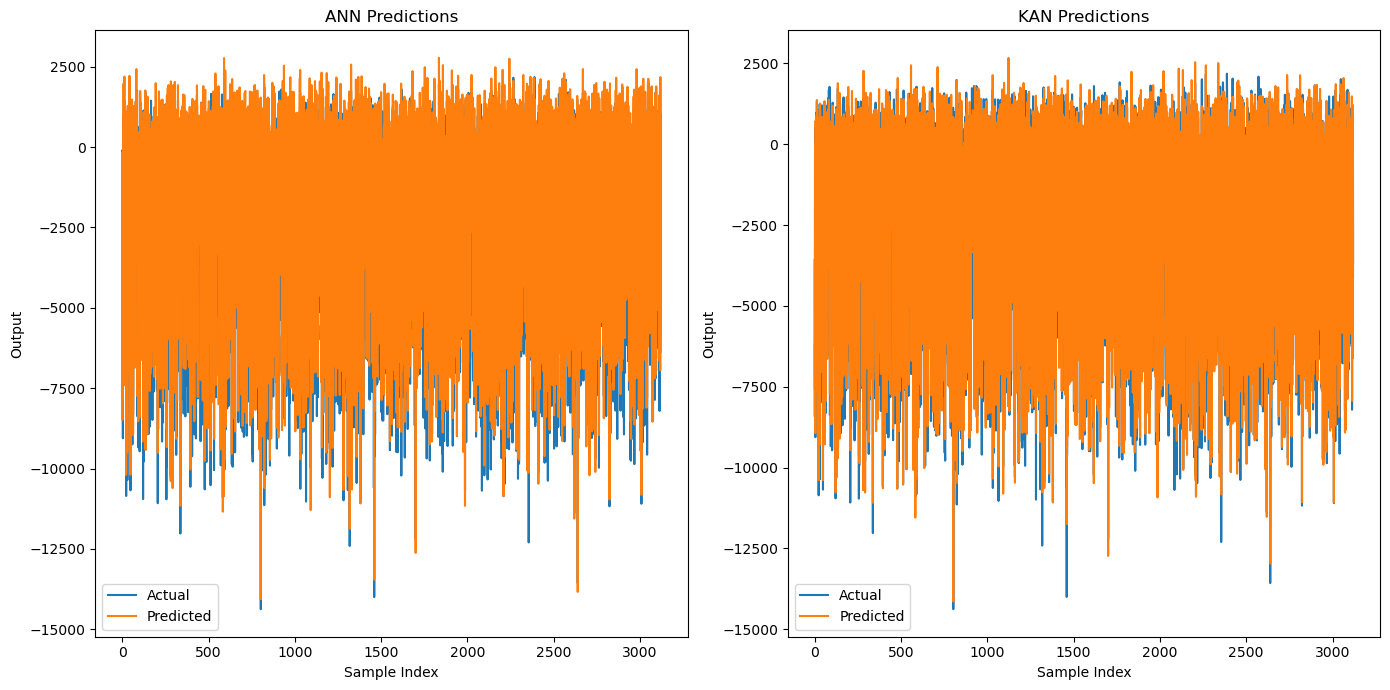

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from kan import KAN, add_symbolic
from torch.utils.data import TensorDataset, DataLoader

# Load the dataset
data_path = 'RoofTypicalDays_Winter Typical.csv'
data = pd.read_csv(data_path)

# Define input and output columns
input_columns = [ 'Temp', 'Dew', 'Hum', 'Pres', 'Area', 'u-Value (Roof)', 'Heat Capacity']
output_column = 'Winter Typical:Heat Flow'

# Prepare the data
X = data[input_columns].values
y = data[output_column].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
x_mean = np.mean(X_train, axis=0)
x_std = np.std(X_train, axis=0)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

X_train_scaled = (X_train - x_mean) / x_std
X_test_scaled = (X_test - x_mean) / x_std
y_train_scaled = (y_train - y_mean) / y_std
y_test_scaled = (y_test - y_mean) / y_std

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Train the ANN model
def train_ann(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the ANN model
def evaluate_ann(model, test_loader, criterion):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    loss = criterion(torch.tensor(predictions), torch.tensor(actuals)).item()
    return predictions, actuals, loss

# Initialize and train the ANN model
ann_model = ANN()
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)
train_ann(ann_model, train_loader, criterion, optimizer, epochs=200)

# Evaluate the ANN model
predictions_ann, actuals_ann, loss_ann = evaluate_ann(ann_model, test_loader, criterion)

# Denormalize the predictions and actuals
predictions_ann_denorm = predictions_ann * y_std + y_mean
actuals_ann_denorm = actuals_ann * y_std + y_mean

# Calculate metrics for ANN
mae_ann = mean_absolute_error(actuals_ann_denorm, predictions_ann_denorm)
mse_ann = mean_squared_error(actuals_ann_denorm, predictions_ann_denorm)
r2_ann = r2_score(actuals_ann_denorm, predictions_ann_denorm)

print(f"ANN Performance: MAE: {mae_ann}, MSE: {mse_ann}, R2: {r2_ann}")

# Train the KAN model using the tutorial's approach
kan_model = KAN(width=[len(input_columns), 20, 1], grid=5, k=3, seed=0)

dataset = {
    'train_input': X_train_tensor,
    'train_label': y_train_tensor,
    'test_input': X_test_tensor,
    'test_label': y_test_tensor
}
kan_model.train(dataset, opt="LBFGS", steps=100, lamb=0.001, lamb_entropy=1.0)


with torch.no_grad():
    predictions_kan_scaled = kan_model(X_test_tensor).numpy()

# Denormalize the predictions and actuals for KAN
predictions_kan_denorm = predictions_kan_scaled * y_std + y_mean

# Calculate metrics for KAN
mae_kan = mean_absolute_error(y_test, predictions_kan_denorm)
mse_kan = mean_squared_error(y_test, predictions_kan_denorm)
r2_kan = r2_score(y_test, predictions_kan_denorm)

data = pd.DataFrame([])
data['predictions_ann_denorm'] = predictions_ann_denorm.flatten()
data['predictions_kan_denorm'] = predictions_kan_denorm.flatten()
data['y_test'] = y_test
data.to_csv('ExtremeValue_Results.csv', index=False)

print(f"KAN Performance: MAE: {mae_kan}, MSE: {mse_kan}, R2: {r2_kan}")

# Plot comparison of actual vs predicted for ANN and KAN
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(actuals_ann_denorm, label='Actual')
plt.plot(predictions_ann_denorm, label='Predicted')
plt.title('ANN Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual')
plt.plot(predictions_kan_denorm, label='Predicted')
plt.title('KAN Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.legend()

plt.tight_layout()
plt.savefig('Prediction_Comparison.png', dpi=300)
plt.show()


## Vis: Extreme Value Capture

Extreme Values Analysis (top 25%):
ANN Metrics:
  MAE: 506.1481
  MSE: 527311.7260
  R2: -3.8133
  MAPE: 56.15%
  SMAPE: 49.59%
  Accuracy (±10%): 13.82%
  Correlation: 0.3433

KAN Metrics:
  MAE: 455.0643
  MSE: 501477.0682
  R2: -3.5774
  MAPE: 48.72%
  SMAPE: 53.49%
  Accuracy (±10%): 15.51%
  Correlation: 0.2724


C:\Users\msi-\AppData\Local\Temp\ipykernel_51316\3434958909.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


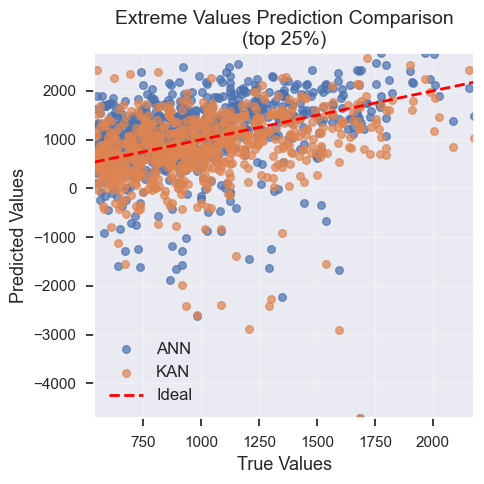

Extreme Values Analysis (top 10%):
ANN Metrics:
  MAE: 518.5182
  MSE: 633739.4029
  R2: -9.1671
  MAPE: 40.54%
  SMAPE: 39.85%
  Accuracy (±10%): 21.61%
  Correlation: 0.2143

KAN Metrics:
  MAE: 510.2343
  MSE: 720328.3798
  R2: -10.5563
  MAPE: 39.05%
  SMAPE: 44.28%
  Accuracy (±10%): 19.68%
  Correlation: 0.1734


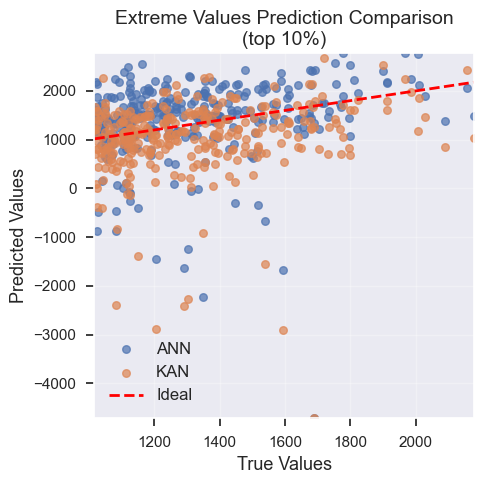

Extreme Values Analysis (top 5%):
ANN Metrics:
  MAE: 520.7827
  MSE: 805616.6160
  R2: -18.2615
  MAPE: 34.94%
  SMAPE: 34.51%
  Accuracy (±10%): 27.92%
  Correlation: 0.2133

KAN Metrics:
  MAE: 588.5522
  MSE: 974713.7299
  R2: -22.3045
  MAPE: 39.27%
  SMAPE: 44.24%
  Accuracy (±10%): 18.83%
  Correlation: 0.1648


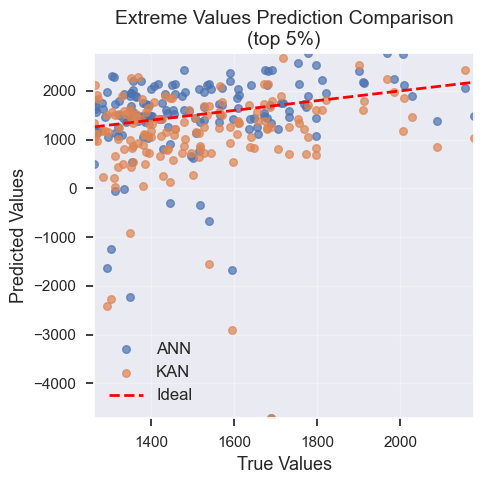

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr


# 设置全局样式
plt.style.use('seaborn')
sns.set_context("notebook")
sns.set_palette("deep")

def analyze_extreme_values(y_true, y_pred_ann, y_pred_kan, percentile=95, outlier_threshold=3):
    threshold = np.percentile(y_true, percentile)
    extreme_indices = np.where(y_true >= threshold)[0]
    
    y_true_extreme = y_true[extreme_indices]
    y_pred_ann_extreme = y_pred_ann[extreme_indices]
    y_pred_kan_extreme = y_pred_kan[extreme_indices]
    
    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
        accuracy_10 = np.mean(np.abs(y_pred - y_true) <= 0.1 * y_true) * 100
        corr, _ = pearsonr(y_true, y_pred)
        return mae, mse, r2, mape, smape, accuracy_10, corr

    # 过滤极端预测值
    valid_indices = (np.abs(y_pred_ann_extreme - y_true_extreme) < outlier_threshold * y_true_extreme) & \
                    (np.abs(y_pred_kan_extreme - y_true_extreme) < outlier_threshold * y_true_extreme)
    
    y_true_filtered = y_true_extreme[valid_indices]
    y_pred_ann_filtered = y_pred_ann_extreme[valid_indices]
    y_pred_kan_filtered = y_pred_kan_extreme[valid_indices]

    metrics_ann = calculate_metrics(y_true_filtered, y_pred_ann_filtered)
    metrics_kan = calculate_metrics(y_true_filtered, y_pred_kan_filtered)
    
    print(f"Extreme Values Analysis (top {100-percentile}%):")
    print("ANN Metrics:")
    print(f"  MAE: {metrics_ann[0]:.4f}")
    print(f"  MSE: {metrics_ann[1]:.4f}")
    print(f"  R2: {metrics_ann[2]:.4f}")
    print(f"  MAPE: {metrics_ann[3]:.2f}%")
    print(f"  SMAPE: {metrics_ann[4]:.2f}%")
    print(f"  Accuracy (±10%): {metrics_ann[5]:.2f}%")
    print(f"  Correlation: {metrics_ann[6]:.4f}")
    
    print("\nKAN Metrics:")
    print(f"  MAE: {metrics_kan[0]:.4f}")
    print(f"  MSE: {metrics_kan[1]:.4f}")
    print(f"  R2: {metrics_kan[2]:.4f}")
    print(f"  MAPE: {metrics_kan[3]:.2f}%")
    print(f"  SMAPE: {metrics_kan[4]:.2f}%")
    print(f"  Accuracy (±10%): {metrics_kan[5]:.2f}%")
    print(f"  Correlation: {metrics_kan[6]:.4f}")
    
    # 可视化极值预测
    fig, ax = plt.subplots(figsize=(5,5), dpi=100)
    
    # 绘制10%精确度区间
#     ax.fill_between(y_true_filtered, y_true_filtered * 0.9, y_true_filtered * 1.1, 
#                     color='lightgray', alpha=0.3, label='±10% Accuracy Zone')
    
    ax.scatter(y_true_filtered, y_pred_ann_filtered, label='ANN', alpha=0.7, s=30)
    ax.scatter(y_true_filtered, y_pred_kan_filtered, label='KAN', alpha=0.7, s=30)
    ax.plot([y_true_filtered.min(), y_true_filtered.max()], 
            [y_true_filtered.min(), y_true_filtered.max()], 
            'r--', label='Ideal', linewidth=2)
    
    ax.set_xlabel('True Values', fontsize=13)
    ax.set_ylabel('Predicted Values', fontsize=13)
    ax.set_title(f'Extreme Values Prediction Comparison\n(top {100-percentile}%)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # 设置坐标轴范围以去除极端值
    ax.set_xlim(y_true_filtered.min(), y_true_filtered.max())
    ax.set_ylim(min(y_pred_ann_filtered.min(), y_pred_kan_filtered.min()),
                max(y_pred_ann_filtered.max(), y_pred_kan_filtered.max()))
    
    # 调整布局
    plt.tight_layout()
    plt.show()

data= pd.read_csv('ExtremeValue_Results.csv')
    
# 使用示例
y_true = data['y_test']  # 实际值
y_pred_ann = data['predictions_ann_denorm']  # ANN预测值
y_pred_kan = data['predictions_kan_denorm']  # KAN预测值

analyze_extreme_values(y_true, y_pred_ann, y_pred_kan, percentile=75, outlier_threshold=4)
analyze_extreme_values(y_true, y_pred_ann, y_pred_kan, percentile=90, outlier_threshold=4)
analyze_extreme_values(y_true, y_pred_ann, y_pred_kan, percentile=95, outlier_threshold=4)